In [1]:
from utils import *

import folium
import geopandas as gpd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])

## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
train_df['is_train'] = 1
test_df['is_train'] = 0

coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_df['latitude']
all_df['longitude'] = coords_df['longitude']

## 3. Removing outliers

In [7]:
all_df = remove_outliers(all_df)

In [8]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

As we found before some prices are fake due to avoid taxes. This situation is more often for `product_type` == 0.

In [17]:
len(train_df[train_df['product_type'] == 0])

19362

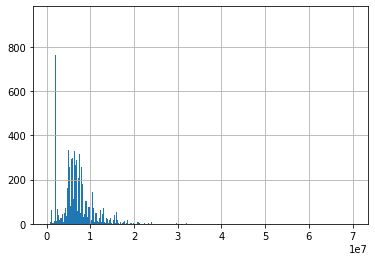

In [14]:
train_df[train_df['product_type'] == 0]['price_doc'].hist(bins=1000);

In [18]:
len(train_df[train_df['product_type'] == 1])

10994

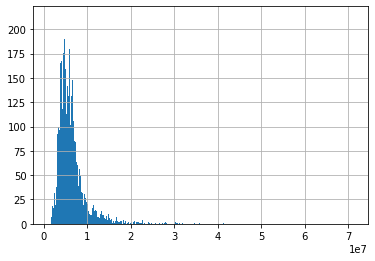

In [15]:
train_df[train_df['product_type'] == 1]['price_doc'].hist(bins=1000);

In [21]:
train_df_0 = train_df[train_df['product_type'] == 0]
test_df_0 = test_df[test_df['product_type'] == 0]

X_0 = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y_0 = train_df_0['price_doc']
X_test_0 = test_df_0.drop(['sub_area'], axis=1).copy()

In [22]:
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_train_0.shape, X_val_0.shape

((15489, 293), (3873, 293))

In [27]:
params = {'n_estimators': 1000,
          'base_score': 7000000,
          'booster': 'gbtree',
          'max_depth': 5,
          'eval_metric': 'mae',
          'learning_rate': 0.05,
          # 'reg_alpha': 30,
          # 'min_child_weight': 10,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'seed': 42,
          'nthread': -1
          }

model_0 = XGBRegressor(objective='reg:squarederror', **params)

model_0.fit(X_train_0, y_train_0, eval_set=[(X_train_0, y_train_0), (X_val_0, y_val_0)], early_stopping_rounds=50)


[0]	validation_0-mae:2842175.00000	validation_1-mae:2837632.25000
[1]	validation_0-mae:2766882.50000	validation_1-mae:2764048.00000
[2]	validation_0-mae:2696550.25000	validation_1-mae:2698122.25000
[3]	validation_0-mae:2636335.50000	validation_1-mae:2639491.75000
[4]	validation_0-mae:2572841.00000	validation_1-mae:2579752.50000
[5]	validation_0-mae:2514446.75000	validation_1-mae:2524637.50000
[6]	validation_0-mae:2459241.50000	validation_1-mae:2471824.00000
[7]	validation_0-mae:2407156.50000	validation_1-mae:2421837.00000
[8]	validation_0-mae:2364135.50000	validation_1-mae:2382564.75000
[9]	validation_0-mae:2328818.75000	validation_1-mae:2348688.00000
[10]	validation_0-mae:2286594.50000	validation_1-mae:2310484.00000
[11]	validation_0-mae:2247565.00000	validation_1-mae:2273334.25000
[12]	validation_0-mae:2210282.25000	validation_1-mae:2239944.25000
[13]	validation_0-mae:2174035.75000	validation_1-mae:2205294.00000
[14]	validation_0-mae:2141530.25000	validation_1-mae:2175585.00000
[15]	

XGBRegressor(base_score=7000000, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='mae',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8, nthread=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [28]:
train_df_1 = train_df[train_df['product_type'] == 1]
test_df_1 = test_df[test_df['product_type'] == 1]

X_1 = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y_1 = train_df_1['price_doc']
X_test_1 = test_df_1.drop(['sub_area'], axis=1).copy()

In [29]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_train_1.shape, X_val_1.shape

((8795, 293), (2199, 293))

In [30]:
params = {'n_estimators': 1000,
          'base_score': 7000000,
          'booster': 'gbtree',
          'max_depth': 5,
          'eval_metric': 'mae',
          'learning_rate': 0.1,
          # 'reg_alpha': 30,
          # 'min_child_weight': 10,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'seed': 42,
          'nthread': -1
          }

model_1 = XGBRegressor(objective='reg:squarederror', **params)

model_1.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_val_1, y_val_1)], early_stopping_rounds=50)


[0]	validation_0-mae:2353449.25000	validation_1-mae:2365667.00000
[1]	validation_0-mae:2157484.00000	validation_1-mae:2167801.50000
[2]	validation_0-mae:1978054.12500	validation_1-mae:1988304.37500
[3]	validation_0-mae:1826493.00000	validation_1-mae:1836339.62500
[4]	validation_0-mae:1684717.12500	validation_1-mae:1696697.62500
[5]	validation_0-mae:1553479.75000	validation_1-mae:1564372.87500
[6]	validation_0-mae:1435471.62500	validation_1-mae:1444229.75000
[7]	validation_0-mae:1327626.75000	validation_1-mae:1339635.37500
[8]	validation_0-mae:1234547.25000	validation_1-mae:1251809.75000
[9]	validation_0-mae:1149960.25000	validation_1-mae:1169599.25000
[10]	validation_0-mae:1082220.25000	validation_1-mae:1109535.50000
[11]	validation_0-mae:1017971.50000	validation_1-mae:1047950.00000
[12]	validation_0-mae:958858.18750	validation_1-mae:992067.06250
[13]	validation_0-mae:909093.68750	validation_1-mae:945255.37500
[14]	validation_0-mae:864383.31250	validation_1-mae:904282.87500
[15]	valida

XGBRegressor(base_score=7000000, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='mae',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8, nthread=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
y_pred_train = np.abs(model_0.predict(X_train_0))
y_pred_val = np.abs(model_0.predict(X_val_0))
print('      TRAIN_0:', np.sqrt(mean_squared_log_error(y_train_0, y_pred_train)))
print(' VALIDATION_0:', np.sqrt(mean_squared_log_error(y_val_0, y_pred_val)))

      TRAIN_0: 0.5067018092213239
 VALIDATION_0: 0.5612375595116483


In [32]:
y_pred_train = np.abs(model_1.predict(X_train_1))
y_pred_val = np.abs(model_1.predict(X_val_1))
print('      TRAIN_1:', np.sqrt(mean_squared_log_error(y_train_1, y_pred_train)))
print(' VALIDATION_1:', np.sqrt(mean_squared_log_error(y_val_1, y_pred_val)))

      TRAIN_1: 0.0355193497940633
 VALIDATION_1: 0.09980222256656789


In [36]:
test_df_nan = test_df[test_df['product_type'].isna()]
X_test_nan = test_df_nan.drop(['sub_area'], axis=1).copy()

In [44]:
submission = pd.read_csv('data/sample_submission.csv', index_col='id')
pred_0 = model_0.predict(X_test_0)
pred_1 = model_1.predict(X_test_1)
pred_nan = model_1.predict(X_test_nan)

if len(pred_0[pred_0 < 0]) or len(pred_1[pred_1 < 0]) or len(pred_nan[pred_nan < 0]):
    print('WARNING: NEGATIVE PREDICTIONS')

In [60]:
submission.loc[X_test_0.index, 'price_doc'] = pred_0
submission.loc[X_test_1.index, 'price_doc'] = pred_1
submission.loc[X_test_nan.index, 'price_doc'] = pred_nan
submission.to_csv('submission.csv', index='id')

In [ ]:
`stacked`

In [61]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "XGBRegressor with product_type split"

100%|████████████████████████████████████████| 121k/121k [00:01<00:00, 81.5kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [ ]:
# !kaggle competitions submissions -c sberbank-russian-housing-market